In [2]:
!pip install torchtext

In [3]:
from collections import Counter, defaultdict
from itertools import islice
from IPython import display
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchtext
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

In [4]:
print(
    f'torch.__version__: {torch.__version__}\n'
    f'torchtext.__version__: {torchtext.__version__}',
)

torch.__version__: 1.8.1+cu101
torchtext.__version__: 0.9.1


In [5]:
tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')
counter = Counter()

train.csv: 29.5MB [00:00, 86.0MB/s]


### Let's look on example

In [6]:
label, text = next(train_iter)

In [7]:
label

3

In [8]:
text

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

### Build Vocabulary and download correspong word embeddings

In [9]:
for (label, line) in AG_NEWS(split='train'):
    counter.update(tokenizer(line))

vocab = Vocab(counter, min_freq=100)

In [10]:
vocab.load_vectors('glove.6B.50d')

.vector_cache/glove.6B.zip: 862MB [02:43, 5.27MB/s]                           
100%|█████████▉| 399802/400000 [00:12<00:00, 31950.00it/s]

In [11]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: int(x) - 1

## Prepare data

In [12]:
class Collator:

    def __init__(self, padding_value: int = 0):
        self.padding_value = padding_value

    def __call__(self, instances):
        max_length = 0
        labels = []
        raw_texts = []

        for label, text in instances:
            labels.append(label_pipeline(label))
            raw_texts.append(text_pipeline(text))

            max_length = max(max_length, len(raw_texts[-1]))

        labels = torch.tensor(labels).long()

        texts = torch.zeros(len(instances), max_length).long().fill_(self.padding_value)
        text_lengths = torch.zeros(len(instances)).long()
        for i, text in enumerate(raw_texts):
            texts[i, :len(text)] = torch.tensor(text).long()
            text_lengths[i] = len(text)
        
        return labels, texts, text_lengths

In [13]:
train_iter = AG_NEWS(split='train')
collator = Collator(padding_value=vocab.stoi['<pad>'])

### Gather two examples into batch

In [14]:
labels, texts, text_lengths = collator([next(train_iter), next(train_iter)])

In [15]:
labels, texts, text_lengths

(tensor([2, 2]),
 tensor([[ 432,  426,    2, 1606,    0,  114,   67,    3,  849,   14,   28,   15,
            28,   16,    0,    4,  432,  375,   17,   10,    0,    7,    0,    4,
            43, 4010,  784,  326,    2,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1],
         [   0, 1073,  855, 1311, 4251,   14,   28,   15,   28,   16,  930,  798,
           321,    0,   99,    4,    0,   29,    6, 4460,   12,  565,    0,    9,
             0, 2126,    8,    3,  526,  242,    4,   29, 3891,    0,    0,   11,
           207,  360,    7,    3,  127,    2]]),
 tensor([29, 42]))

In [34]:
BATCH_SIZE = 64

collator = Collator(padding_value=vocab.stoi['<pad>'])

## Conv+Attention Model

In [35]:
from typing import Tuple

In [36]:
from torch import nn

class ConvAttentionModel(nn.Module):

    def __init__(
        self,
        num_class: int,
        input_dim: int = 50,
        hidden_dim: int = 128,
        kernel_sizes: Tuple[int] = (3, 5, 7),
        embeddings: torch.Tensor = None,
        num_embeddings: int = None
    ):
        super().__init__()
        
        # Load pretrained word embeddigs or init random
        if embeddings is not None:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        else:
            assert num_embeddings is not None
            self.embeddings = nn.Embedding(num_embeddings, input_dim)
        
        # Convs
        convs = [
            nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size // 2)
            for kernel_size in kernel_sizes
        ]
        self.convs = nn.ModuleList(convs)
        self.projection = nn.Conv1d(hidden_dim * len(kernel_sizes), hidden_dim, kernel_size=1)

        # Attention (aka Bahdanau attention)
        self.energy = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Classifier
        self.clf = nn.Linear(hidden_dim, num_class)
    
    @staticmethod
    def get_padding_mask(lengths: torch.Tensor) -> torch.Tensor:
        max_length = torch.max(lengths).item()
        
        # padding elements are indicated by `True`
        mask = (
            torch.arange(max_length, device=lengths.device)
            .ge(lengths.view(-1, 1))
            .contiguous()
            .bool()
        )

        return mask

    
    def forward(self, input, lengths = None):
        # input.shape == [B, T]
        input = self.embeddings(input)
        
        # input.shape == [B, input_dim, T]
        input = input.transpose(-1, -2)

        # Convs
        conv_logits = []
        for conv_module in self.convs:
            conv_logits.append(
                conv_module(input)
            )
        
        # Concat along features
        # conv_logits.shape == [B, hidden_dim * len(kernel_sizes), T]
        conv_logits = torch.cat(conv_logits, dim=1)
        
        # conv_logits.shape == [B, hidden_dim, T]
        conv_logits = self.projection(conv_logits)
        
        # Attention Pooling
        # energies.shape == [B, T, 1]
        energies = self.energy(conv_logits.transpose(-1, -2))
        
        # Sentences have different length
        # so we need to mask padding `energies` before softmax
        if lengths is not None:
            padding_mask = self.get_padding_mask(lengths)
            energies = energies.masked_fill(
                padding_mask.unsqueeze(dim=-1),
                value=float('-inf')
            )
            
        prob_energies = torch.softmax(energies, dim=-2)
        output = (conv_logits * prob_energies.transpose(-1, -2)).sum(dim=-1)
        logits = self.clf(output)
        
        return logits

## Training

In [37]:
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [41]:
NUM_EPOCH = 10
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = ConvAttentionModel(num_class=10, embeddings=vocab.vectors).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

history = defaultdict(list)

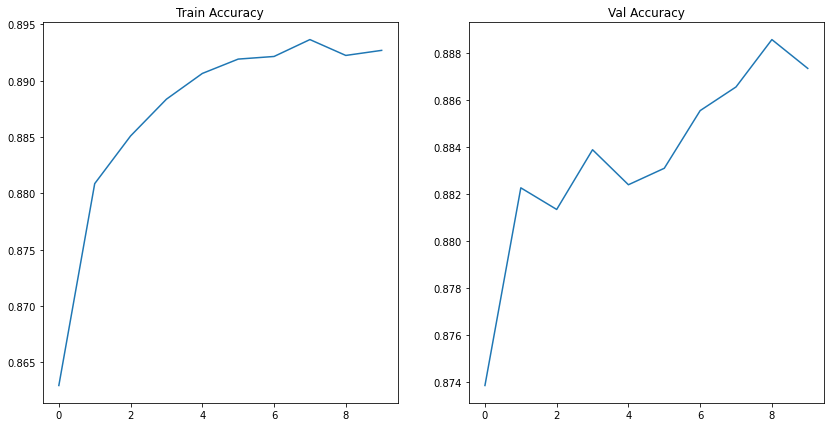

In [42]:
for epoch in range(NUM_EPOCH):
    train_accuracy_meters = AverageMeter()

    # Adhoc since `AG_NEWS` return generator
    train_dataloader = DataLoader(
        AG_NEWS(split='train'),
        batch_size=BATCH_SIZE,
        collate_fn=collator
    )

    model.train()
    for labels, texts, text_lengths in train_dataloader:
        labels = labels.to(DEVICE)
        texts = texts.to(DEVICE)
        text_lengths = text_lengths.to(DEVICE)
        
        logits = model(texts, text_lengths)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_accuracy_meters.update(
            (logits.argmax(dim=-1) == labels).float().mean().item()
        )
    
    history['train_accuracy'].append(train_accuracy_meters.avg)
        
    val_accuracy_meter = AverageMeter()
    val_dataloader = DataLoader(
        AG_NEWS(split='test'),
        batch_size=BATCH_SIZE,
        collate_fn=collator
    )
    
    model.eval()
    for labels, texts, text_lengths in val_dataloader:
        labels = labels.to(DEVICE)
        texts = texts.to(DEVICE)
        text_lengths = text_lengths.to(DEVICE)
        
        with torch.no_grad():
            logits = model(texts, text_lengths)
        
        val_accuracy_meter.update(
            (logits.argmax(dim=-1) == labels).float().mean().item()
        )
    
    history['val_accuracy'].append(val_accuracy_meter.avg)
    
    display.clear_output()
    fig, axis = plt.subplots(1, 2, figsize=(14, 7))
    axis[0].plot(history['train_accuracy'])
    axis[0].set_title('Train Accuracy')
    
    axis[1].plot(history['val_accuracy'])
    axis[1].set_title('Val Accuracy')
    plt.show()